In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
# !pip install -e ../../objFuncs
# !pip install -e ../../pyBO

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from phantasy import caget

In [5]:
import objFuncs
from objFuncs import residuals
from objFuncs.util import plot_obj_history, plot_multi_obj_history

objFuncs version: 1.0.2. updated on 2023-12-19


# check machineIO, source and beam 

In [6]:
objFuncs._global_machineIO._test = False
objFuncs._ensure_set_timeout = 60
objFuncs._global_machineIO._fetch_data_time_span = 2.0
objFuncs._global_machineIO._ensure_set_timewait_after_ramp : 0.25
objFuncs._global_machineIO.view()

   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.0
   _return_obj_var : False
   _check_chopper_blocking : True
   _n_popup_ramping_not_OK : 0
   _verbose : False


In [7]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS2 238U35 A/Q= 6.8


# preprare objective (for residual construction)

In [8]:
now0 = datetime.datetime.now()
now0str = now0.strftime('%Y%m%d_%H%M')
fname = now0str+'['+ion+'][LSQ][FS1][after1stDipole]QuadCentering_FS1bDump'
fname

'20231219_0540[238U35][LSQ][FS1][after1stDipole]QuadCentering_FS1bDump'

In [9]:
decision_CSETs=[
    'FS1_CSS:PSC2_D2381:I_CSET',
    'FS1_BBS:PSD_D2394:I_CSET',
    'FS1_CSS:PSC1_D2381:I_CSET',
    'FS1_BBS:PSC1_D2412:I_CSET'
]

decision_min = []
decision_max = []
for PV in decision_CSETs:
    x0 = caget(PV)
    if 'PSC' in PV:
        decision_min += [x0 -0.3*AQ]
        decision_max += [x0 +0.3*AQ]
    elif 'PSD' in PV:
        decision_min += [x0* 0.9995]
        decision_max += [x0* 1.0005]


print(f'decision_min: {decision_min}')
print(f'decision_max: {decision_max}')

decision_min: [-8.321584570737986, 149.792311290811, 0.9971569768520157, 49.337029038932805]
decision_max: [-4.241584570737986, 149.94217853572425, 5.077156976852016, 53.4170290389328]


In [10]:
objective_goal = { 
    'FS1_BTS:BPM_D2467:XPOS_RD' : 0.0,
    'FS1_BTS:BPM_D2467:YPOS_RD' : 0.0,
#     'FS1_BMS:BPM_D2502:XPOS_RD' : 0.0,
#     'FS1_BMS:BPM_D2502:YPOS_RD' : 0.0,
#     'FS1_BMS:BPM_D2537:XPOS_RD' : 0.0,
#     'FS1_BMS:BPM_D2537:YPOS_RD' : 0.0,
}
objective_norm = {pv:1.0 for pv in objective_goal.keys()}
objective_weight = {pv:1.0 for pv in objective_goal.keys()}
objective_RDs = list(objective_goal.keys())

In [11]:
conditional_SETs = {
    'FS1_BBS:PSQ_D2416:I_CSET':[],
    'FS1_BBS:PSQ_D2424:I_CSET':[],
}

In [12]:
for i,PV in enumerate(conditional_SETs.keys()):
    x0 = caget(PV)
    conditional_SETs[PV] = [x0]*(2*len(conditional_SETs)+1)
    conditional_SETs[PV][2*i+1] = x0 - 2*AQ
    conditional_SETs[PV][2*i+2] = x0 + 2*AQ

In [13]:
n_condition = len(list(conditional_SETs.values())[0])
conditional_SETs

{'FS1_BBS:PSQ_D2416:I_CSET': [169.250892,
  155.650892,
  182.850892,
  169.250892,
  169.250892],
 'FS1_BBS:PSQ_D2424:I_CSET': [75.834417,
  75.834417,
  75.834417,
  62.234417,
  89.434417]}

In [14]:
res = residuals.residualObjMultiConditionalVar(  
    decision_CSETs = decision_CSETs,
    decision_min = decision_min,
    decision_max =  decision_max,
    objective_goal = objective_goal,
    objective_norm = objective_norm,
    objective_weight = objective_weight,
    conditional_SETs = conditional_SETs,
    var_obj_weight_fraction = 1.0,
    )

[condition_controller] ======== class info ========
init_time: 2023-12-19 05:40:30.683369
class_hierarchy: [
    objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f7b885acc10>
decision_CSETs: [
    FS1_BBS:PSQ_D2416:I_CSET, FS1_BBS:PSQ_D2424:I_CSET]
decision_min: [155.650892  62.234417]
decision_max: [182.850892  89.434417]
decision_bounds: [[155.650892 182.850892]
 [ 62.234417  89.434417]]
decision_RDs: [
    FS1_BBS:PSQ_D2416:I_RD, FS1_BBS:PSQ_D2424:I_RD]
decision_tols: [6. 6.]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: condition_controler
logging_fname: None
x0: [169.250892  75.834417]

[condition 0] ======== class info ========
init_time: 2023-12-19 05:40:33.713570
class_hierarchy: [
    residualObj, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f7b8176ac90>
decision_CSETs: [
    FS1_CSS:PSC2_D2381:I_CSET, FS1_BBS:PSD_D2394:I_CSET, FS1_CSS:PSC1_D2381:I_CSET
    

In [15]:
plot_decision = plot_obj_history(
    res.history['decision_CSETs'],
    keys = [[k for k in decision_CSETs if 'PSD' in k],[k for k in decision_CSETs if 'PSC' in k]],
    title='decision_CSETs',
)
plot_conditions_RDs = plot_multi_obj_history(
    histories = [res.history['condition'+str(i)]['objective_RDs'] for i in range(n_condition)],
    history_labels = ['C'+str(i) for i in range(n_condition)],
    title='multi-condition_obj_RDs',
)
plot_objectives_var = plot_obj_history(
    res.history['objectives_var'],
    title='objectives_var',
)
plot_cond_control = plot_obj_history(
    res.history['condition controller']['decision_CSETs'],
    title='condition controller',
)

callbacks = [plot_decision,plot_conditions_RDs,plot_objectives_var,plot_cond_control]
# callbacks = []

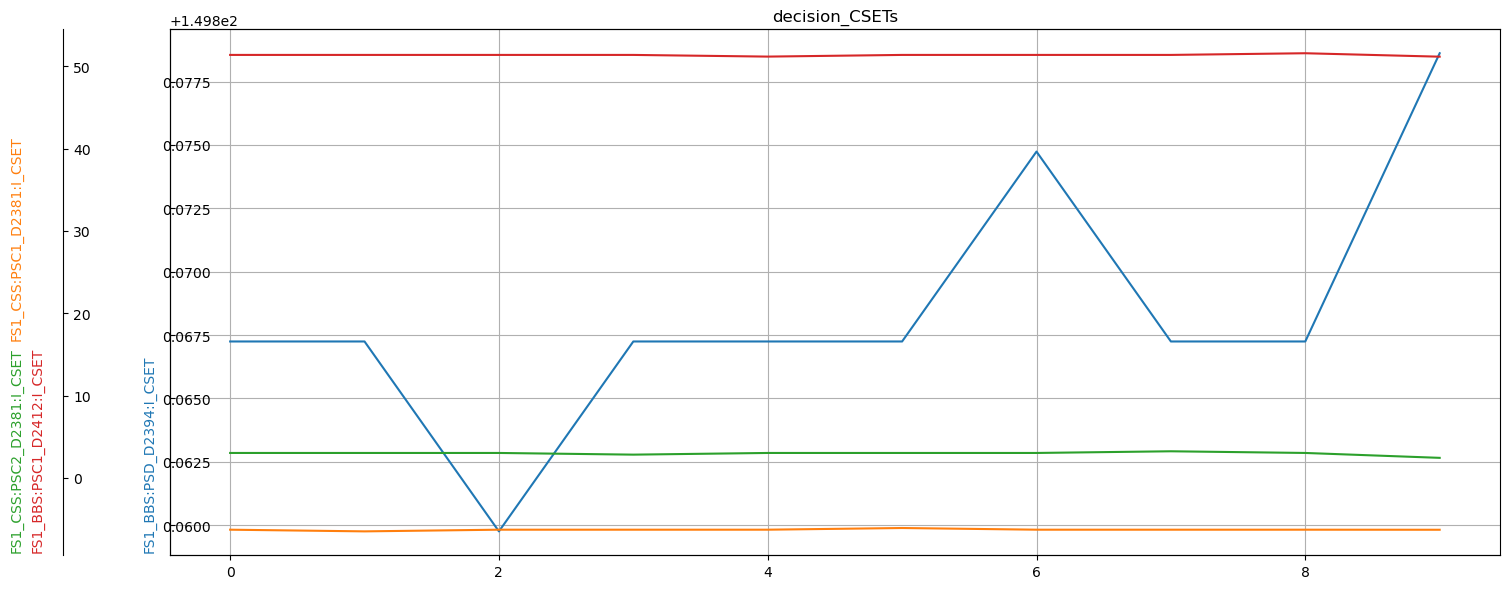

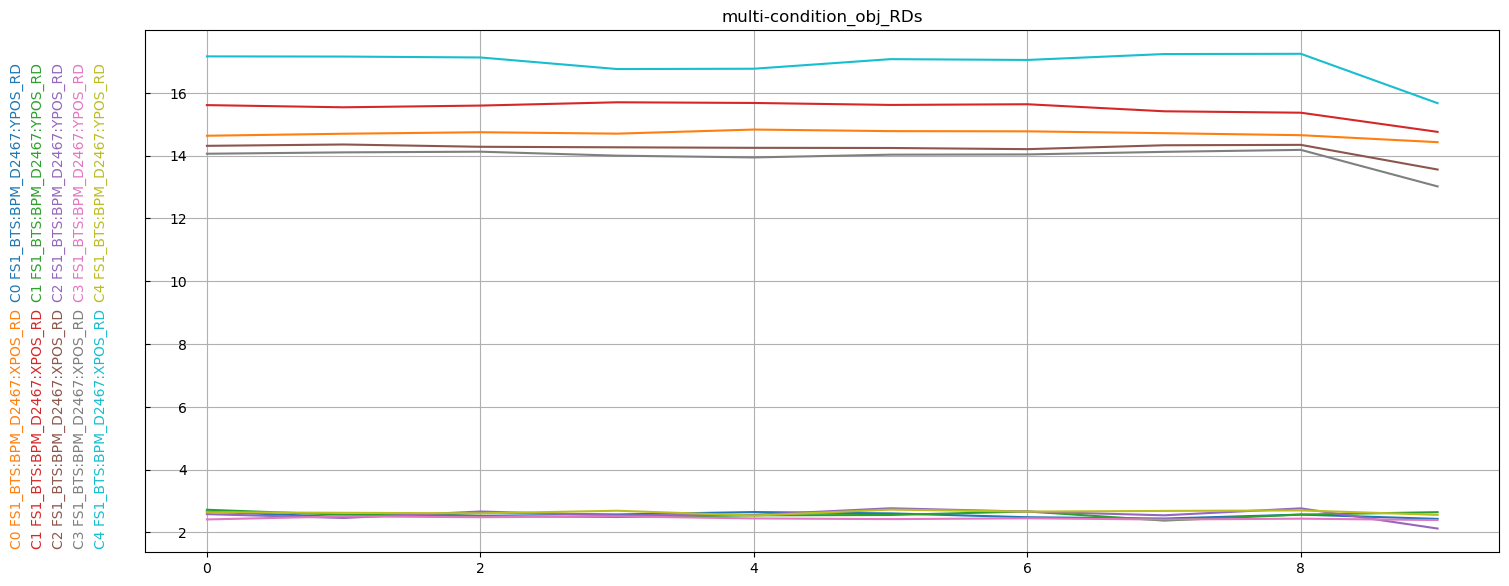

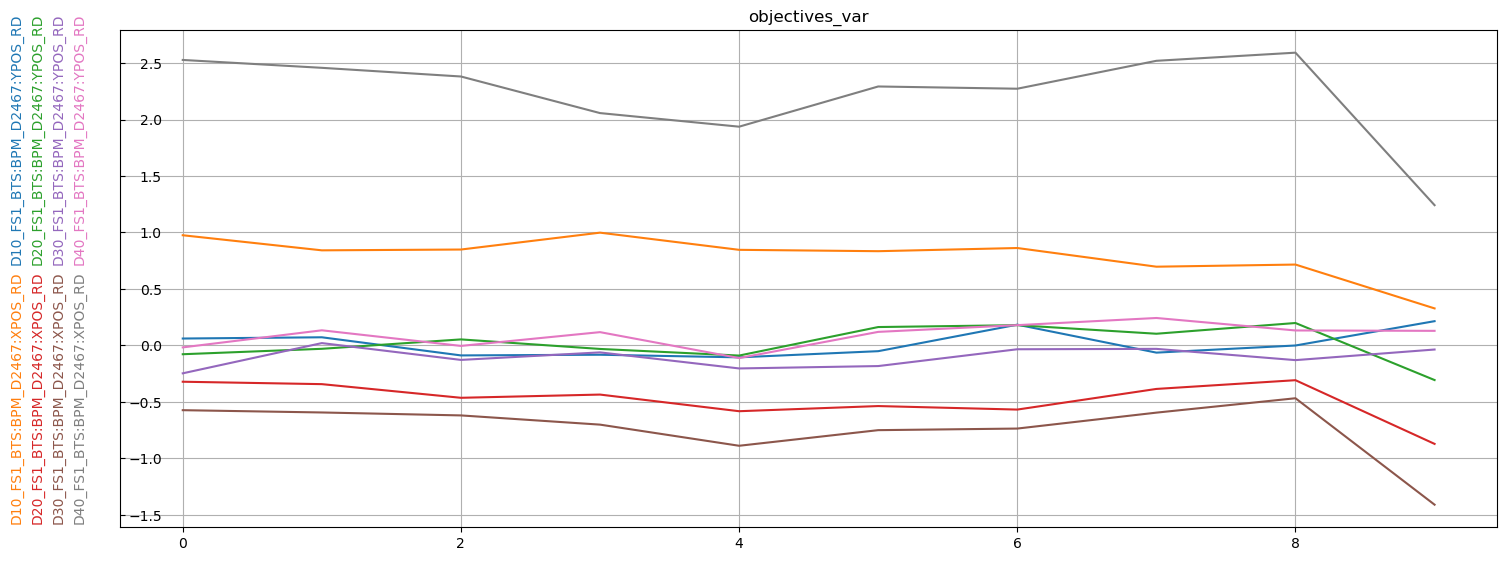

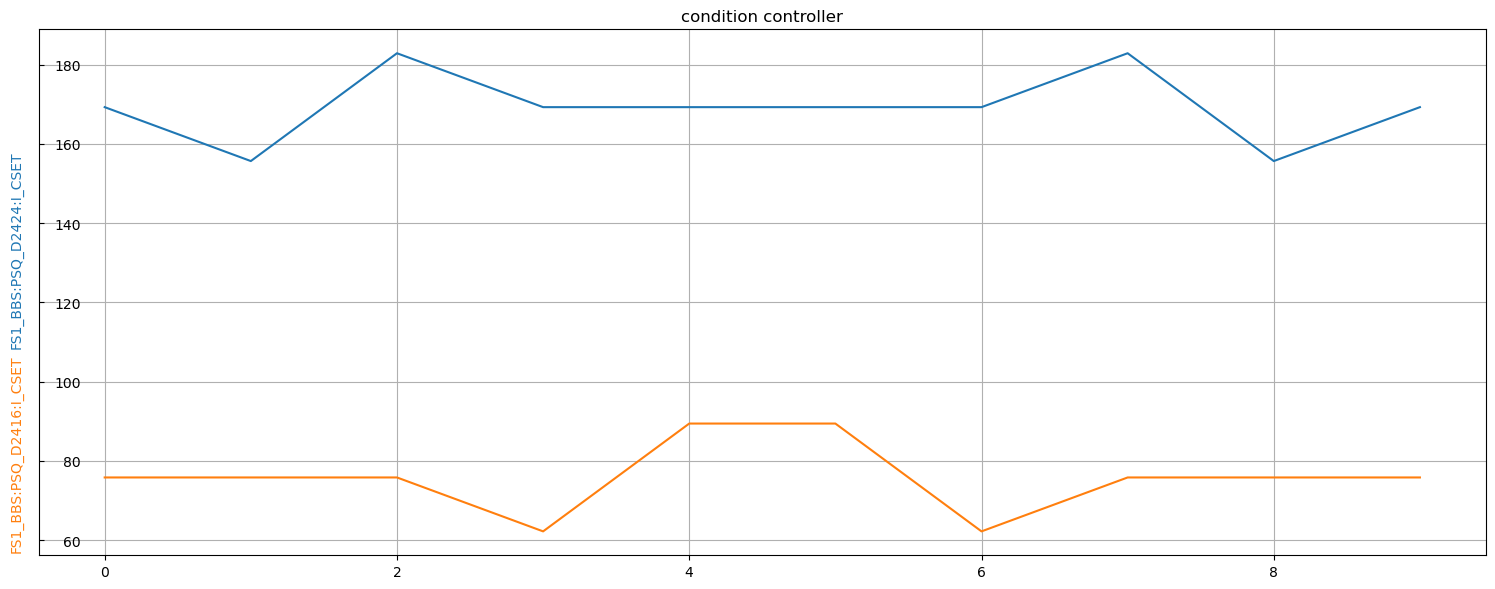

In [16]:
result = res.lsq_linear(jac_use3points=True,callbacks=callbacks)
res.condition_controller._set_decision(res.condition_controller.x0)
for f in callbacks:
    f.close()

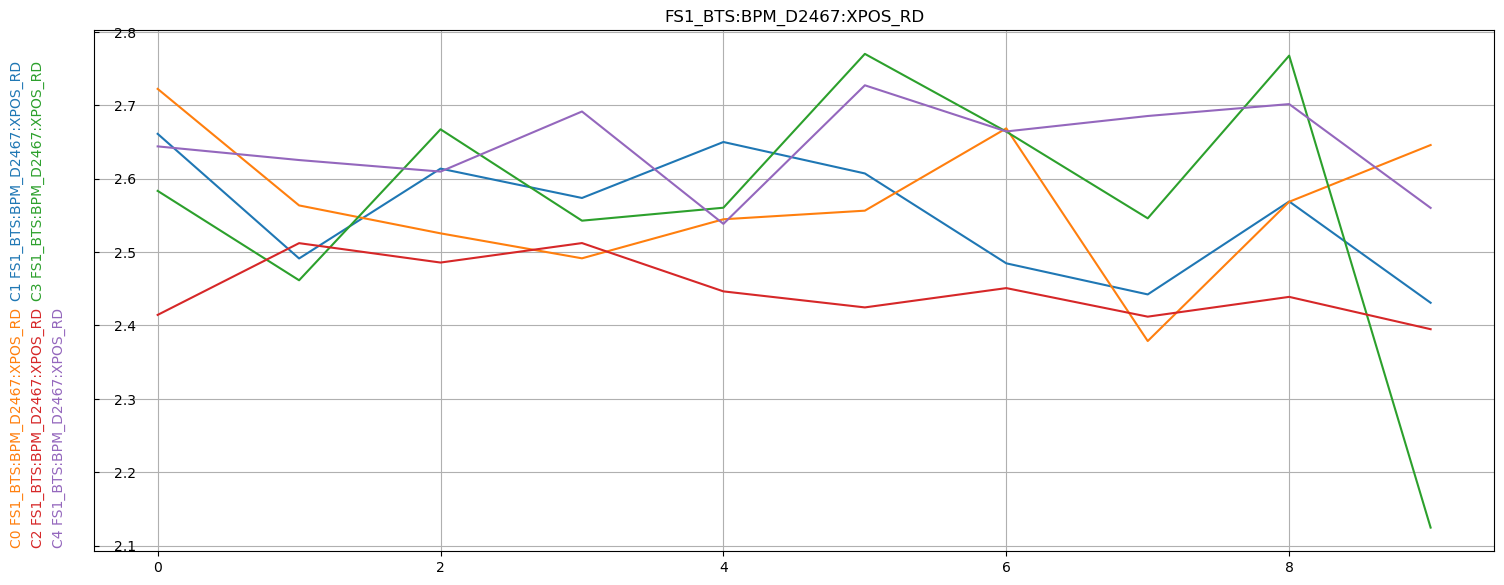

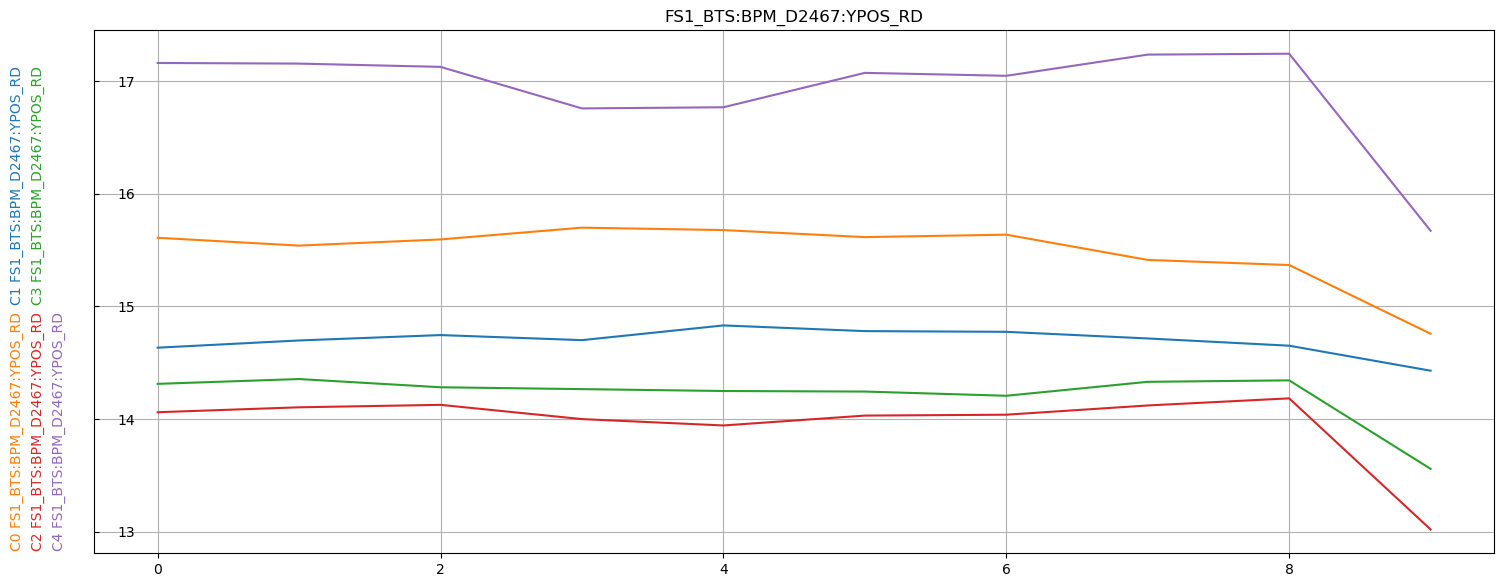

In [17]:
for key in objective_goal.keys():
    plot_conditions_RDs = plot_multi_obj_history(
        histories = [res.history['condition'+str(i)]['objective_RDs'] for i in range(n_condition)],
        history_labels = ['C'+str(i) for i in range(n_condition)],
        title= key,
        keys = [[key]],
    )
    plot_conditions_RDs()
    plot_conditions_RDs.close()

In [18]:
res.write_log(fname=os.path.join('./log',fname))

only .pkl file extension is accepted. saving to: ./log/20231219_0540[238U35][LSQ][FS1][after1stDipole]QuadCentering_FS1bDump.pkl


In [19]:
np.sum(res.history['objectives_var']['values'][0]**2)

7.840709658507626

In [20]:
np.sum(res.history['objectives_var']['values'][-1]**2)

4.553259483659528

In [21]:
# xnew = [caget(PV) for PV in decision_CSETs]

In [22]:
# res(np.array(xnew))

In [23]:
# res.condition_controller._set_decision(res.condition_controller.x0)